# Final Project - Movie Reviews Analysis
- **Team 13: Jimmy Nguyen, Dallin Munger, Tyler Wolff**



# Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
import spacy
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Define function to display topics for the topic models (directly from BTAP repo)
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

/home/jimmynguyen/anaconda3/envs/ads509/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Data

In [2]:
# Read in the cleaned plot data
plot_data = pd.read_csv('Cleaned Plot Data.csv')
# View dataframe
plot_data.sample(5)

,title,first_genre,cleaned_plot,imdb_rating
394,The Perfect One,drama,"['new', 'mother', 'dealing', 'postpartum', 'de...",5.6
115,Father There Is Only One,comedy,"['family', 'father', 'discovers', 'hard', 'car...",6.0
1656,"One Wish for Iran, Love Israel",documentary,"['one', 'wish', 'iran', 'love', 'israel', 'hig...",NaN
1817,One Hundred Steps,documentary,"['forty', 'years', 'frank', 'garfunkel', 'taug...",NaN
913,The Lucky One,comedy,"['countryman', 'arrives', 'athens', 'make', 'b...",5.0


In [3]:
# Untokenize plot descriptions
plot_data['cleaned_plot'] = plot_data['cleaned_plot'].str.replace(r'[^\w\s]', '', regex= True).str.strip()
plot_data['cleaned_plot'].sample(5)

1806    sensitive portrait psychotic glamorous drugadd...
496     gold lion shiki offered alliance gol roger lat...
1734    modern day parable setting mail package proces...
903     early 1980s beginning would become 12yearlong ...
1620    wal junior meg get selected go france study la...
Name: cleaned_plot, dtype: object

In [4]:
# TF-IDF text vectorization
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=3)
plot_data_tfidf = tfidf_text_vectorizer.fit_transform(plot_data["cleaned_plot"])
plot_data_tfidf.shape

(1828, 2414)

# Topic Modeling

### Non-Negative Matrix Factorization

In [5]:
# Non-Negative Matrix Factorization Model
plot_nmf_model = NMF(n_components=5, random_state=42)
W_text_matrix = plot_nmf_model.fit_transform(plot_data_tfidf)
H_text_matrix = plot_nmf_model.components_

# Show results of the topic model
display_topics(plot_nmf_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  young (2.01)
  man (1.94)
  woman (1.49)
  love (1.49)
  girl (0.91)

Topic 01
  documentary (3.88)
  film (3.86)
  short (1.53)
  new (1.04)
  making (0.77)

Topic 02
  story (7.19)
  tells (1.62)
  based (1.29)
  journey (1.11)
  true (0.98)

Topic 03
  life (7.42)
  years (1.29)
  art (0.85)
  musician (0.70)
  jokes (0.70)

Topic 04
  day (8.09)
  lives (1.51)
  night (1.07)
  peace (0.96)
  city (0.86)


In [6]:
# Create document-topic dataframe and add genre column
def genre_by_topic(df):
    document_topic = pd.DataFrame(df)
    topic_genre = pd.concat([document_topic.idxmax(axis=1), plot_data['first_genre']], axis=1)
    topic_genre.columns = ['topic', 'genre']
    return topic_genre.groupby(['topic', 'genre']).size()
genre_by_topic(W_text_matrix)

topic  genre      
0      action          68
       animation       52
       comedy         210
       documentary     92
       drama          210
1      action          20
       animation       28
       comedy          59
       documentary    313
       drama           31
2      action          28
       animation       31
       comedy          34
       documentary    124
       drama           68
3      action          11
       animation       16
       comedy          45
       documentary    120
       drama           71
4      action           5
       animation       18
       comedy          32
       documentary     94
       drama           48
dtype: int64

The NMF topic model appears to spread each genre around within each topic. Topic 0 has a higher concentration of drama and comedy. Topic 1 does appear to group documentary primarily, but the last 3 topics appear to just spread the top 3 genres around. It is difficult to determine which topic would match with which genre.

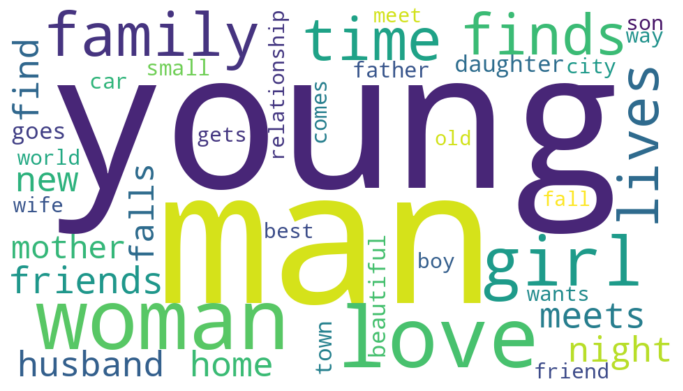

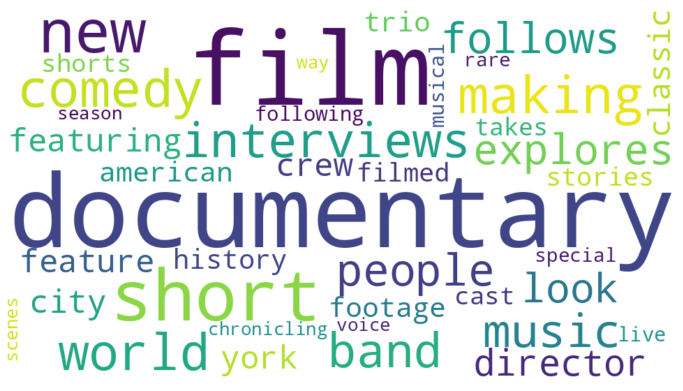

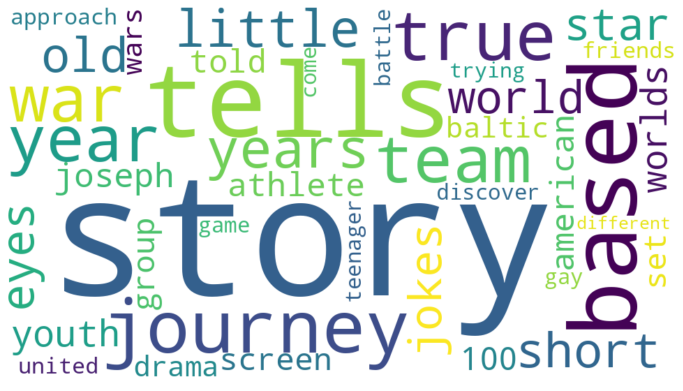

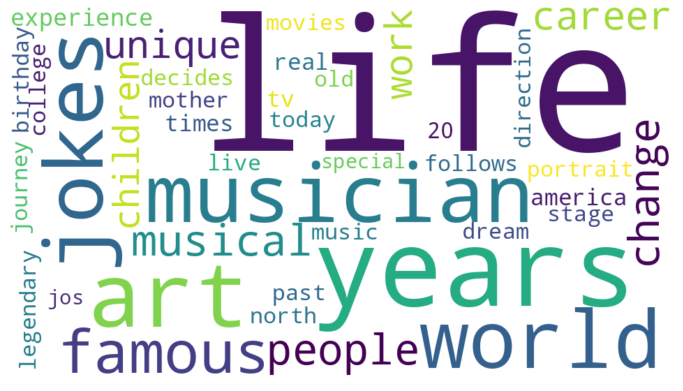

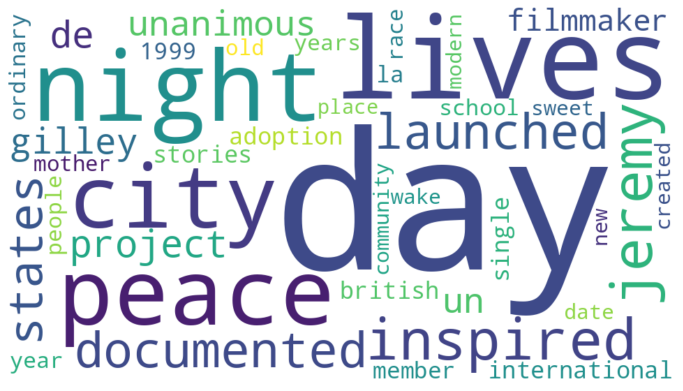

In [7]:
# display word cloud function
def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100,
            width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")


#NMF Word Cloud for Review


wordcloud_topics(plot_nmf_model, tfidf_text_vectorizer.get_feature_names())

### Latent Dirichlet Allocation

In [8]:
# Create Topics For LDA
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=3)
count_para_vectors = count_para_vectorizer.fit_transform(plot_data['cleaned_plot'])
lda_para_model = LatentDirichletAllocation(n_components=5, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

display_topics(lda_para_model, count_para_vectorizer.get_feature_names())


Topic 00
  film (1.26)
  world (1.23)
  documentary (1.02)
  love (0.92)
  girl (0.66)

Topic 01
  life (2.30)
  film (1.18)
  new (1.14)
  world (0.98)
  story (0.88)

Topic 02
  young (1.25)
  man (1.21)
  night (0.94)
  story (0.68)
  lives (0.63)

Topic 03
  story (1.48)
  man (0.92)
  film (0.92)
  life (0.85)
  years (0.84)

Topic 04
  young (1.19)
  woman (1.03)
  man (0.93)
  love (0.78)
  life (0.74)


In [9]:
# Compare LDA topic modeling to original genres
genre_by_topic(W_lda_para_matrix)

topic  genre      
0      action          18
       animation       33
       comedy          53
       documentary    179
       drama           56
1      action          31
       animation       21
       comedy          61
       documentary    221
       drama           83
2      action          28
       animation       49
       comedy         100
       documentary     85
       drama          104
3      action          19
       animation       16
       comedy          78
       documentary    171
       drama           91
4      action          36
       animation       26
       comedy          88
       documentary     87
       drama           94
dtype: int64

Once again, it appears the genres are spread across topics. Each genre has one topic where there is a slightly higher concentration, but overall there is a fairly even distribution across groups.

In [10]:
lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors,
 count_para_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

/home/jimmynguyen/anaconda3/envs/ads509/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/jimmynguyen/anaconda3/envs/ads509/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/jimmynguyen/anaconda3/envs/ads509/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/jimmynguyen/anaconda3/envs/ads509/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


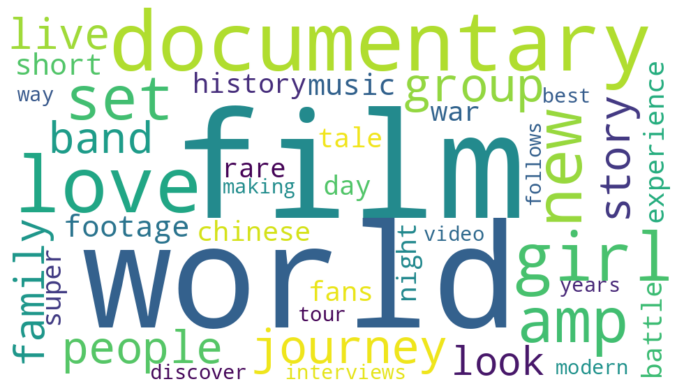

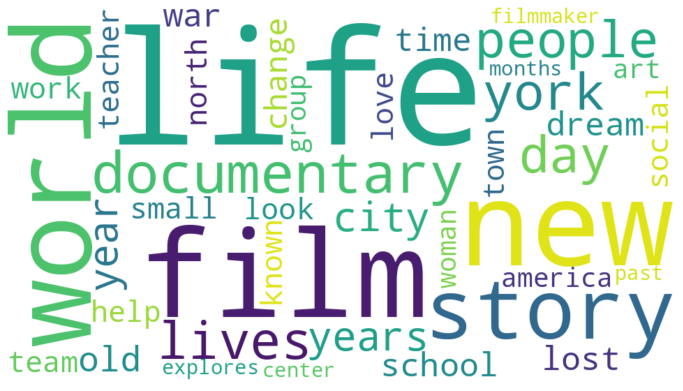

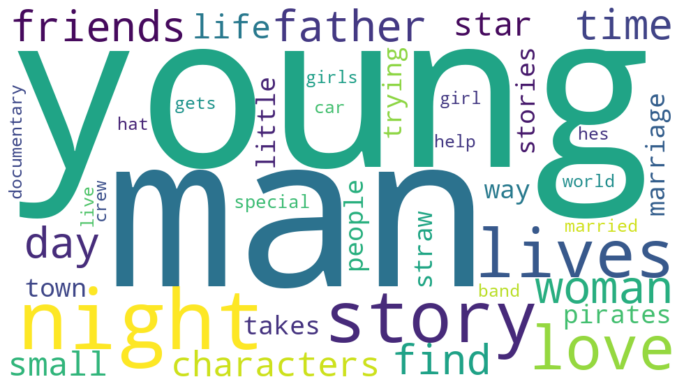

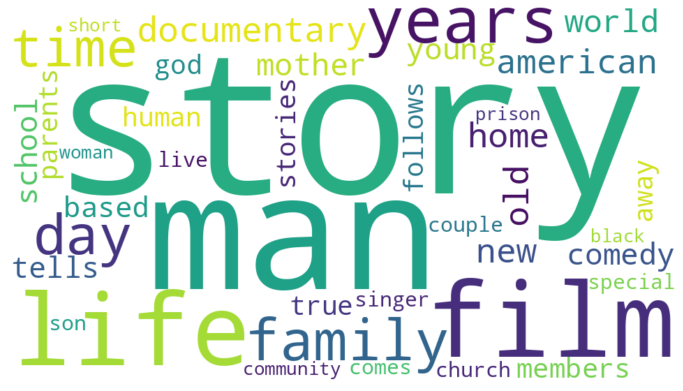

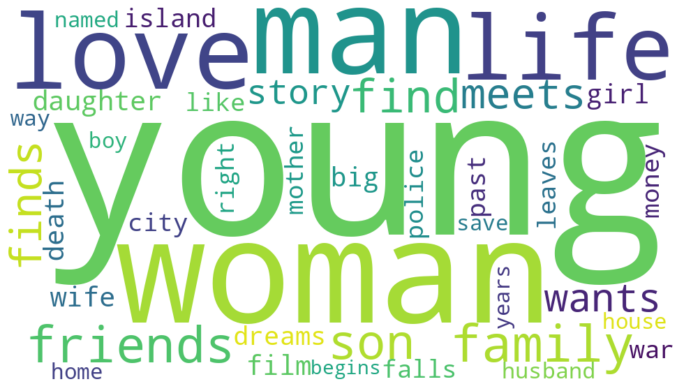

In [11]:
#LDA Word Cloud for Review
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names())

# Recommendations

1. Add more genres in the future (Where it can pull multiple genres if the plot fits in more than one) 
2. More in depth design with the application to make it more attractive for the user
3. Train the models on shorter descriptions (Currently accuracy with less words is down)
4. Create a model that can work for longer plot descriptions that way if a movie writer was unsure of the genre of their future film they can put the entire plot into the application and then it will give them an accurate genre 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=53ef1faa-b7a9-4637-b54c-3b067e58670d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>